In [30]:
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn import decomposition
import sys
import torch
import umap

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
import decode_1d, geometry_util

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device {}".format(device))

using device cuda


First load in the data. This was generated from raw spikes using the preprocessing notebook located in the same folder as this one. Spikes were simply convolved with a Gaussian kernel to produce rates, as standard.

In [32]:
data_dir = "/home/trevor/manifold_test_data/torus/gardner_data/10k_bins"
all_data = np.load(os.path.join(data_dir, "all_mod_encoded_points.npy"), allow_pickle=True)
data = np.transpose(all_data[-1])

Do some linear dimensionality reduction to make things easier. The solution doesnt seem to sensitive to this. They use 6 in the original paper.

In [33]:
pca_instance = decomposition.PCA(n_components=8)
proj_data = pca_instance.fit_transform(np.sqrt(data))
normed_rates = proj_data/np.mean(np.abs(proj_data))

Now find the Torus.

In [34]:
decoder_hidden_size = 1000
encoder_hidden_size = int(1.5 * decoder_hidden_size)
decoder_n_hidden = 2
encoder_n_hidden = decoder_n_hidden

In [37]:
encoder, decoder, _ = decode_1d.train(data=normed_rates, n_circular_dimensions=2, n_linear_dimensions=0, device=device,
                                                   n_training_iterations=2000, decoder_weight=1, order_red_weight=1, batch_size=50, encoder_hidden_dim=encoder_hidden_size, encoder_n_hidden=encoder_n_hidden, decoder_hidden_dim=decoder_hidden_size, decoder_n_hidden=decoder_n_hidden)


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.6252214908599854, distance cost: 0.05269581824541092, order reduction: 0.015031578950583935
iteration: 2, decoding loss: 1.51723051071167, distance cost: 0.06023980304598808, order reduction: 0.02178596518933773
iteration: 3, decoding loss: 1.3247666358947754, distance cost: 0.047524064779281616, order reduction: 0.01762806437909603
iteration: 5, decoding loss: 1.2356427907943726, distance cost: 0.022547153756022453, order reduction: 0.015257545746862888
iteration: 6, decoding loss: 1.1584583520889282, distance cost: 0.021822618320584297, order reduction: 0.015102945268154144
iteration: 8, decoding loss: 1.0347001552581787, distance cost: 0.019514702260494232, order reduction: 0.016324372962117195
iteration: 11, decoding loss: 0.9861149191856384, distance cost: 0.021291717886924744, order reduction: 0.017901675775647163
iteration: 12, decoding loss: 0.9198538064956665, distance cost: 0.02751336246728897, order reduction: 0.017920883372426033
iteration: 13

We can plot some 2D projections. It will be hard to interpret these, as the manifod we have found is 2D. I am mainly looking at the shapes of the data and detected manifold to see if they line up. This isn't that useful.

In [38]:
n_projections = 6
embed_dim = np.shape(normed_rates)[1]
random_projections = np.random.normal(0, 1, (n_projections, 2, embed_dim))
col_norm = np.einsum("ijk, ijk -> ik", random_projections, random_projections)
normed_proj = np.einsum("ijk, ik -> ijk", random_projections, 1/np.sqrt(col_norm))
projected_data = np.einsum("bk, ijk -> bij", normed_rates, normed_proj)

In [40]:
test_angles = np.random.uniform(0, 2 * np.pi, (1000, 2))
with torch.no_grad():
    test_embedding = encoder(torch.tensor(test_angles, dtype=torch.get_default_dtype()).to(device))
test_embedding = test_embedding.cpu().numpy()
projected_test_embedding = np.einsum("bk, ijk -> bij", test_embedding, normed_proj)


Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.8/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/trevor/brainvenv/lib/python3.8/site-packages/matplotlib/backends/_backend_tk.py", line 210, in filter_destroy
    CloseEvent("close_event", self)._process()
  File "/home/trevor/brainvenv/lib/python3.8/site-packages/matplotlib/backend_bases.py", line 1230, in _process
    self.canvas.callbacks.process(self.name, self)
  File "/home/trevor/brainvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 312, in process
    self.exception_handler(exc)
  File "/home/trevor/brainvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 96, in _exception_printer
    raise exc
  File "/home/trevor/brainvenv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 307, in process
    func(*args, **kwargs)
  File "/home/trevor/brainvenv/lib/python3.8/site-packages/matplotlib/backend_bases.py

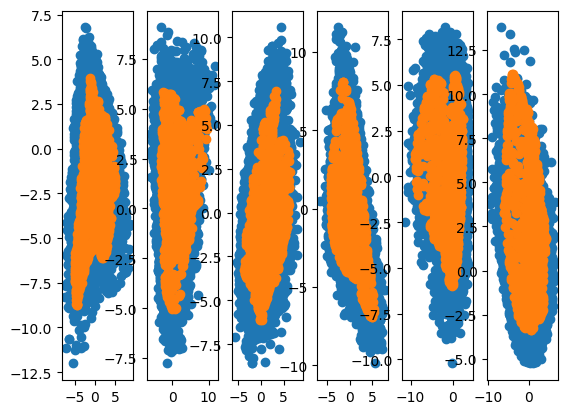

In [41]:
%matplotlib inline
data_plot_density = 1
fig, axs = plt.subplots(ncols=n_projections)
for i in range(n_projections):
    axs[i].scatter(projected_data[::data_plot_density, i, 0], projected_data[::data_plot_density, i, 1], color="C0")
    axs[i].scatter(projected_test_embedding[:, i, 0], projected_test_embedding[:, i, 1], color="C1")


Now we will try and form a 3D visualization of the fit manifold. I'll use UMAP to generate a random 3D embedding. If we're lucky it will have a hole in it.

In [42]:
embedding_fn = umap.UMAP(n_components=3, n_neighbors=5)
embedding_fn.fit(proj_data)


UMAP(n_components=3, n_neighbors=5, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [43]:
isomapped_data = embedding_fn.transform(proj_data)


Now i'll generate some traces of the identified manifold. I do this by sparsely sampling the first phase and densely sampling the second, then plot lines constant in the first phase.

In [44]:
outer_angles = np.arange(start=0, stop=2*np.pi, step=0.5)
inner_angles = np.linspace(start=0, stop=2 * np.pi, num=1000)
all_surface_data = []
for angle in outer_angles:
    test_angles = np.zeros((1000,2))
    test_angles[:, 0] = inner_angles
    test_angles[:, 1] = angle
    all_surface_data.append(test_angles)
all_surface_data = np.stack(all_surface_data)
all_surface_data_flat = np.reshape(all_surface_data, (-1, 2))

with torch.no_grad():
    surface_points = encoder(torch.tensor(all_surface_data_flat, dtype=torch.get_default_dtype()).to(device))
surface_points = surface_points.cpu().numpy()


In [45]:
isomapped_surface = embedding_fn.transform(surface_points)
isomapped_surface = np.reshape(isomapped_surface, (*np.shape(all_surface_data)[:-1], -1))


In [46]:
%matplotlib tk
proj_fig = plt.figure()
proj_axs = proj_fig.add_subplot(projection="3d")
plot_density = 1
proj_axs.scatter(isomapped_data[::plot_density, 0], isomapped_data[::plot_density, 1], isomapped_data[::plot_density, 2], alpha=0.1)
for i in range(np.shape(isomapped_surface)[0]):
    proj_axs.plot(isomapped_surface[i, :, 0], isomapped_surface[i, :, 1], isomapped_surface[i, :, 2])


The quality of the visualization generated by above varies alot depending on how well UMAP works. Here is an example of a good looking decoding:

[Decoding Image](https://drive.google.com/file/d/1CwZxeiNJRcGjWFkA3Fkg0GW20jooCN_V/view?usp=share_link)

The data and fit manifold have been distorted by UMAP, so the details of the manifold shape are meaningless. The important thing is that the identified manifold shares the hole present in the data!